In [22]:
import io
import os
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow

class_area = {'21': 1985, '2': 5415, '18': 6969, '26': 17849, '8': 7037, '20': 6110, '25': 6532, '32': 16411, '28': 17179, '7': 6771, '9': 6689, '12': 5510, '22': 5795, '24': 2808, '11': 6129, '23': 8645, '29': 17181, '4': 6132, '31': 16001, '5': 4808, '15': 3737, '17': 5721, '19': 6769, '30': 11940, '16': 3564, '13': 6558, '1': 4575, '6': 3126, '10': 8179, '27': 18761, '14': 13607, '3': 6903}


TEST_DATASET_PATH = "D:/Veilex/_test/train-segment-data/datasets/custom_dataset/dataset/test"
images_dir = "images"
labels_dir = "labels"

# the file id for the model in google dirve
model_file_id = "1rd0GmerO8wzWBcAr5e38_WOXYLJqTDKl"

In [23]:
SCOPES = ["https://www.googleapis.com/auth/drive"]

def download_file(file_id):
    file = None
    creds = None
    # The file token.json stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists("token.json"):
        creds = Credentials.from_authorized_user_file("token.json", SCOPES)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                "credentials.json", SCOPES
            )
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open("token.json", "w") as token:
            token.write(creds.to_json())

    try:
        # create drive api client
        service = build("drive", "v3", credentials=creds)

        request = service.files().get_media(fileId=file_id)
        file = io.BytesIO()
        downloader = MediaIoBaseDownload(file, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print(f"Download {int(status.progress() * 100)}.")

    except HttpError as error:
        print(f"An error occurred: {error}")
        file = None

    return file.getvalue()

yolo_model_pid_bytes = download_file(file_id=model_file_id)

Download 100.


In [24]:
from ultralytics import YOLO

model_file_path = "yolo-model-pid.pt"

# testing if model can be loaded.
if not os.path.exists(model_file_path):
    with open(model_file_path, 'wb') as f:
        f.write(yolo_model_pid_bytes)

model = YOLO(model_file_path)

In [25]:
from typing import List, Tuple
from src.models.vertex import Vertex
from src.models.pid_data_point import PidDataPoint
from src.models.symbol import Symbol
from src.utils.denormalize_coordinates import denormalize_coordinates

from PIL import Image


def read_yolo_label_data(label_path: str) -> List[Tuple[str, float, float, float, float]]:
    with open(label_path, 'r') as file:
        lines = file.readlines()

    labels = []
    for line in lines:
        class_id, x, y, _x, _y = line.strip().split()
        labels.append((class_id, float(x), float(y), float(_x), float(_y)))
    return labels
    

pid_test_dataset = []

dataset_images_path = f"{TEST_DATASET_PATH}/{images_dir}"
dataset_labels_path = f"{TEST_DATASET_PATH}/{labels_dir}"
image_files = [os.path.join(dataset_images_path, f) for f in os.listdir(dataset_images_path) if os.path.isfile(os.path.join(dataset_images_path, f))]

for image_file_path in image_files:
    datapoint = PidDataPoint(
        image_path=image_file_path
    )
    image = Image.open(image_file_path)
    image_file_name = '.'.join(image_file_path.split("\\")[-1].split(".")[0:-1])
    label_dp_path = os.path.join(dataset_labels_path, f"{image_file_name}.txt")
    if os.path.isfile(label_dp_path):
        yolo_datalabel = read_yolo_label_data(label_dp_path)
        symbols = []
        for l in yolo_datalabel:
            class_id, x, y, _x, _y = l
            x, y, _x, _y = denormalize_coordinates([x, y, _x, _y], image.width, image.height)
            symbols.append(
                Symbol(
                    label=class_id,
                    name="",
                    pointSrc=Vertex(x=x, y=y),
                    pointDest=Vertex(x=_x, y=_y)
                )
            )
        datapoint.symbols = symbols
    
    pid_test_dataset.append(datapoint)


In [26]:
from src.services.predict_symbols_service import PredictSymbolsService


def predict_results():
    predicted_results = []
    for index, d in enumerate(pid_test_dataset[:5]):
        predict_service = PredictSymbolsService(
            image_path=d.image_path,
            model_path=model_file_path
        )

        bboxes_with_labels = predict_service.predict_bounding_boxes()
        predicted_results.append(bboxes_with_labels)

    return predicted_results

predicted_results = predict_results()


0: 1088x1088 1 14, 1 21, 1 32, 105.8ms
Speed: 6.5ms preprocess, 105.8ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)
time took to finish prediction: 0.17077898979187012

0: 1088x1088 1 3, 3 5s, 1 9, 1 10, 1 15, 1 21, 1 25, 2 28s, 1 32, 97.2ms
Speed: 5.0ms preprocess, 97.2ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)
time took to finish prediction: 0.14925742149353027

0: 1088x1088 1 2, 1 4, 1 22, 1 28, 1 31, 104.5ms
Speed: 5.0ms preprocess, 104.5ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)
time took to finish prediction: 0.15880823135375977

0: 1088x1088 1 8, 1 12, 1 19, 1 21, 1 22, 1 25, 1 26, 1 29, 103.0ms
Speed: 7.1ms preprocess, 103.0ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)
time took to finish prediction: 0.1730175018310547

0: 1088x1088 1 5, 1 20, 1 21, 105.1ms
Speed: 4.0ms preprocess, 105.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)
time took to finish pr

In [27]:
predicted_results

[[([879.8729858398438,
    378.10687255859375,
    994.6038818359375,
    505.20648193359375],
   '14'),
  ([849.8284912109375, 59.3841438293457, 979.2515258789062, 187.4505615234375],
   '32'),
  ([536.8956909179688,
    378.14776611328125,
    569.3073120117188,
    440.0269470214844],
   '21')],
 [([595.19970703125, 540.6663208007812, 712.1820678710938, 628.8284301757812],
   '10'),
  ([634.0052490234375,
    257.3110046386719,
    718.8758544921875,
    321.0689392089844],
   '3'),
  ([304.5430603027344, 828.1495361328125, 406.88311767578125, 888.46044921875],
   '5'),
  ([371.85748291015625,
    523.3359985351562,
    470.7179260253906,
    622.8003540039062],
   '25'),
  ([87.47782135009766,
    542.0814208984375,
    165.71351623535156,
    603.7669677734375],
   '5'),
  ([508.541259765625, 370.6865539550781, 579.7445068359375, 474.6044616699219],
   '9'),
  ([614.0078125, 799.4119873046875, 734.4483032226562, 917.1216430664062],
   '28'),
  ([893.9596557617188,
    222.93634033

In [28]:
from src.services.predict_symbols_service import PredictSymbolsService
from src.services.image_display_serivce import ImageDisplayService
import numpy as np
from scipy.optimize import linear_sum_assignment

def mean_square_error_with_matching(actual_boxes, predicted_boxes) -> float:
    """
    Calculate the mean square error (MSE) between actual and predicted bounding boxes,
    accounting for mismatched order by using optimal matching (Hungarian algorithm).
    
    Parameters:
    actual_boxes: List of actual bounding boxes [(x1, y1, x2, y2), ...]
    predicted_boxes: List of predicted bounding boxes [(x1, y1, x2, y2), ...]

    Returns:
    float: Mean square error value
    """

    if len(actual_boxes) > len(predicted_boxes):
        for _ in range(abs(len(actual_boxes) - len(predicted_boxes))):
            predicted_boxes.append([0, 0, 0, 0])
    
    if len(predicted_boxes) > len(actual_boxes):
        for _ in range(abs(len(actual_boxes) - len(predicted_boxes))):
            actual_boxes.append([0, 0, 0, 0])

    if len(actual_boxes) != len(predicted_boxes):
        raise ValueError("The number of actual and predicted boxes must be the same.")
    
    # Convert to numpy arrays for efficient computation
    actual_boxes = np.array(actual_boxes)
    predicted_boxes = np.array(predicted_boxes)
    
    # Compute the cost matrix (pairwise squared errors)
    cost_matrix = np.zeros((len(actual_boxes), len(predicted_boxes)))
    for i, actual in enumerate(actual_boxes):
        for j, predicted in enumerate(predicted_boxes):
            cost_matrix[i, j] = np.mean((actual - predicted) ** 2)
    
    # Solve the assignment problem using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Calculate the total MSE based on the optimal assignment
    mse = 0.0
    for i, j in zip(row_ind, col_ind):
        mse += cost_matrix[i, j]
    
    mse /= len(actual_boxes)
    return mse

def bbox_area_valid(annotation_prediction):
    bbox = annotation_prediction[0]
    class_id = annotation_prediction[1]
    predicted_area = (abs(bbox[0] - bbox[2])) * (abs(bbox[1] - bbox[3]))
    return predicted_area > class_area[class_id] * 0.6

# mean squre error in testing the images with symbols
def calculate_test_pid_mse():
    not_including_in_testing = 0
    sum = 0
    for index, d in enumerate(predicted_results):
        # filtered_result = [bl for bl in d if bbox_area_valid(bl)] # [bl[0] for bl in d]
        predicted_bboxes = [bl[0] for bl in d] # [bl[0] for bl in filtered_result] 
        actual_bboxes = []
        for s in pid_test_dataset[index].symbols:
            x, y = s.pointSrc.get_dimensions()
            _x, _y = s.pointDest.get_dimensions()
            actual_bboxes.append([x, y, _x, _y])
        
        mse = 0
        try:
            mse += mean_square_error_with_matching(actual_bboxes, predicted_bboxes)
        except:
            not_including_in_testing += 1
            print(f"could not caculate MSE of the datapoint {index}") 

        sum += mse
    print("not included in dataset ", not_including_in_testing)
    print("Mean Square Error, ", sum / (len(pid_test_dataset) - not_including_in_testing))

calculate_test_pid_mse()

not included in dataset  0
Mean Square Error,  21.494651569136565


In [29]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def calculate_iou(box1, box2) -> float:
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    box1, box2: (x1, y1, x2, y2)
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Compute the area of the intersection rectangle
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Compute the area of both boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # Compute the union area
    union_area = box1_area + box2_area - inter_area
    
    # Compute IoU
    return inter_area / union_area if union_area != 0 else 0

def accuracy_with_iou(actual_boxes, predicted_boxes, iou_threshold=0.5) -> float:
    """
    Calculate the percentage accuracy of the predicted bounding boxes using IoU.
    
    Parameters:
    actual_boxes: List of actual bounding boxes [(x1, y1, x2, y2), ...]
    predicted_boxes: List of predicted bounding boxes [(x1, y1, x2, y2), ...]
    iou_threshold: IoU threshold to consider a match as correct
    
    Returns:
    float: Accuracy percentage
    """
    if len(actual_boxes) > len(predicted_boxes):
        for _ in range(abs(len(actual_boxes) - len(predicted_boxes))):
            predicted_boxes.append([0, 0, 0, 0])
    
    if len(predicted_boxes) > len(actual_boxes):
        for _ in range(abs(len(actual_boxes) - len(predicted_boxes))):
            actual_boxes.append([0, 0, 0, 0])

    if len(actual_boxes) != len(predicted_boxes):
        raise ValueError("The number of actual and predicted boxes must be the same.")
    
    # Compute the IoU cost matrix
    cost_matrix = np.zeros((len(actual_boxes), len(predicted_boxes)))
    for i, actual in enumerate(actual_boxes):
        for j, predicted in enumerate(predicted_boxes):
            cost_matrix[i, j] = -calculate_iou(actual, predicted)  # Negate for maximization
    
    # Solve the assignment problem using the Hungarian algorithm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Count correct matches based on the IoU threshold
    correct_matches = 0
    for i, j in zip(row_ind, col_ind):
        iou = -cost_matrix[i, j]  # Undo the negation
        if iou >= iou_threshold:
            correct_matches += 1
    
    # Compute accuracy
    accuracy = (correct_matches / len(actual_boxes)) * 100
    return accuracy

# percentage accuracy of PID
def calculate_test_pid_accuracy():
    not_including_in_testing = 0
    sum = 0
    for index, d in enumerate(predicted_results):
        # predict_service = PredictSymbolsService(
        #     image_path=d.image_path,
        #     model_path=model_file_path
        # )

        # bboxes_with_labels = predict_service.predict_bounding_boxes()
        predicted_bboxes = [bl[0] for bl in d]

        actual_bboxes = []
        for s in pid_test_dataset[index].symbols:
            x, y = s.pointSrc.get_dimensions()
            _x, _y = s.pointDest.get_dimensions()
            actual_bboxes.append([x, y, _x, _y])
        
        accuracy = 0
        try:
            accuracy += accuracy_with_iou(actual_bboxes, predicted_bboxes)
        except:
            not_including_in_testing += 1
            print(f"Could not test MSE of the datapoint {index}") 

        sum += accuracy

    print("Accuracy")
    print(sum / (len(pid_test_dataset) - not_including_in_testing))
    print("datapoints not included in testing ", not_including_in_testing)

calculate_test_pid_accuracy()

Accuracy
0.337952832482373
datapoints not included in testing  0


### Testing the accuracy on full images

In [34]:
pid_dataset_path = "D:/Veilex/_test/dataset/DigitizePID_Dataset"
from config import config
from src.services.data_converter_service import DataConverterService
from src.services.predict_symbols_service import PredictSymbolsService


# change the config here. This should not be done anywhere else btw, this is exception
config.dataset_path = pid_dataset_path
config.image_dir_name = "image_2"
config.annotation_dir_name = "annotations"

data_service = DataConverterService()
full_pid_dataset = data_service.load_dataset()

def predict_full_dataset_results():
    predicted_results = []
    for d in full_pid_dataset[0:10]:
        predict_service = PredictSymbolsService(
            image_path=d.image_path,
            model_path=model_file_path
        )

        bboxes_with_labels = predict_service.predict_bounding_boxes(shifting=True)
        predicted_results.append(bboxes_with_labels)

    return predicted_results

predicted_full_results: List[PidDataPoint] = predict_full_dataset_results()
    


0: 1088x1088 (no detections), 112.1ms
Speed: 4.2ms preprocess, 112.1ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 1 9, 119.3ms
Speed: 0.0ms preprocess, 119.3ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 1 2, 1 8, 1 11, 1 12, 1 20, 1 21, 1 24, 2 25s, 120.5ms
Speed: 0.0ms preprocess, 120.5ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 (no detections), 123.5ms
Speed: 0.0ms preprocess, 123.5ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 224x1088 (no detections), 45.0ms
Speed: 0.0ms preprocess, 45.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 1088)

0: 1088x1088 1 12, 3 21s, 2 22s, 1 26, 109.8ms
Speed: 0.0ms preprocess, 109.8ms inference, 0.0ms postprocess per image at shape (1, 3, 1088, 1088)

0: 1088x1088 1 2, 1 12, 1 18, 1 20, 2 21s, 1 22, 2 26s, 1 29, 112.6ms
Speed: 6.5ms preprocess, 112.6ms inference, 0.0ms postprocess per image 

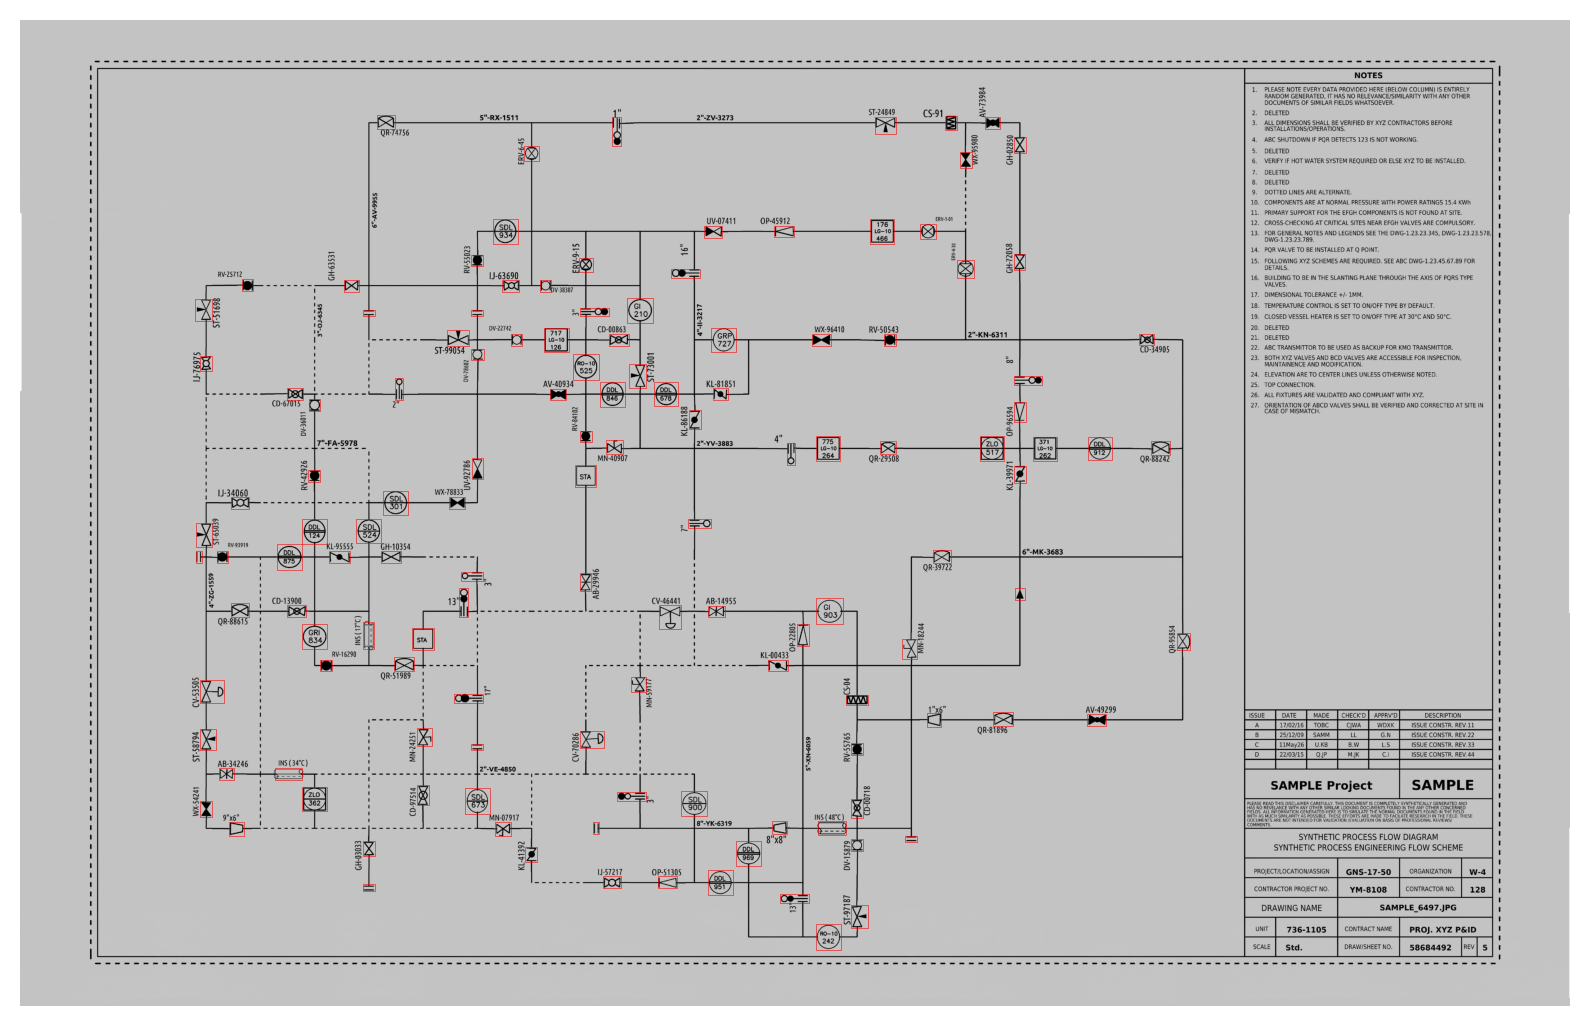

In [38]:
from src.utils.convert_points_to_bounding_box import convert_points_to_bounding_box
from src.services.image_display_serivce import ImageDisplayService

index = 9

instance = predicted_full_results[index]
service = ImageDisplayService(
    image_path=full_pid_dataset[index].image_path,
    bounding_boxes=[convert_points_to_bounding_box(i[0]) for i in instance ]
)

service.display_image_with_bbox()

In [37]:
def calculate_full_pid_dataset_accuracy():
    not_including_in_testing = 0
    sum = 0
    for index, d in enumerate(predicted_full_results):
        predicted_bboxes = [bl[0] for bl in d]

        actual_bboxes = []
        for s in full_pid_dataset[index].symbols:
            x, y = s.pointSrc.get_dimensions()
            _x, _y = s.pointDest.get_dimensions()
            actual_bboxes.append([x, y, _x, _y])
        
        accuracy = 0
        try:
            print( len(actual_bboxes), len(predicted_bboxes) )
            accuracy += accuracy_with_iou(actual_bboxes, predicted_bboxes)
        except:
            not_including_in_testing += 1
            print(f"Could not test MSE of the datapoint {index}") 

        sum += accuracy

    print("Accuracy")
    print(sum / (len(predicted_full_results) - not_including_in_testing))
    print("datapoints not included in testing ", not_including_in_testing)

calculate_full_pid_dataset_accuracy()

90 90
92 92
105 106
121 121
105 104
119 118
105 104
115 114
119 119
131 131
Accuracy
99.46016043825242
datapoints not included in testing  0
